In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/home/anirudh/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
with open('config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = config["source_epochs"]
LR = 1e-4
IN_SHAPE = config["image_shape"]
MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]
center_disp, center_scale, amp_scale, amp_disp = config["lens_centers_disp"], config["lens_centers_scale"], config["lens_amp_scale"], config["lens_amp_disp"]
resolution = config["resolution"]/(MAGNIFICATION*N_MAG)

In [4]:
BATCH_SIZE = 5
dataset = data.LensingDataset('/home/anirudh/Documents/GSoC/DeepLense_2024/Simulations/data_model_1/',['no_sub'],5000)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [5]:
i_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["i_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)
# s_model = models.RegressionCNN(n_outputs=2).to(device)

alpha = torch.tensor([[config["alpha"] for _ in range(IN_SHAPE*MAGNIFICATION*N_MAG)] for __ in range(IN_SHAPE*MAGNIFICATION*N_MAG)]).to(device)
sersic_loss = models.SersicProfiler(in_shape=IN_SHAPE*MAGNIFICATION*N_MAG, resolution=resolution, device=device, alpha=alpha, BATCH_SIZE=BATCH_SIZE, sersic_args = [20, 1, 0.25])

# opt = torch.optim.Adam(params=s_model.parameters(),lr=LR)
i_params = sum(p.numel() for p in i_model.parameters())
print(f"Image network parameters: {i_params}")
# s_params = sum(p.numel() for p in s_model.parameters())
# print(f"Source network parameters: {s_params}")

Image network parameters: 899843


In [6]:
def give_random_image(dataset, model1, length):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    i = np.random.randint(low=0,high=length)
    LR = dataset[i]
    t = LR.clone().detach().view(1,1,IN_SHAPE,IN_SHAPE)
    image = model1(t.float().to(device)).cpu().detach()
    sersic_profile, source_profile = sersic_loss.get_sample(image)
    image1 = Image.fromarray(image.numpy()[0][0]*255)
    image2 = Image.fromarray(sersic_profile.cpu().detach().numpy()*255)
    image3 = Image.fromarray(source_profile.cpu().detach().numpy()[0][0]*255)
    return (Image.fromarray(t.numpy()[0][0]*255), image1, image2, image3)

def show_random_image(image_tuple):
    image0, image1, image2, image3 = image_tuple[0], image_tuple[1], image_tuple[2], image_tuple[3]
    plot, axes = plt.subplots(1,4)
    plot.set_size_inches(24,6)
    axes[0].imshow(image0)
    axes[1].imshow(image1)
    axes[2].imshow(image2)
    axes[3].imshow(image3)
    axes[0].set_title("LR")
    axes[1].set_title("Image")
    axes[2].set_title("Sersic profile")
    axes[3].set_title("Source")

In [7]:
i_model.load_state_dict(torch.load('bicubic.pt'))

<All keys matched successfully>

tensor([86], device='cuda:0') tensor([74], device='cuda:0')
tensor([0.2750], device='cuda:0') tensor([0.0250], device='cuda:0')


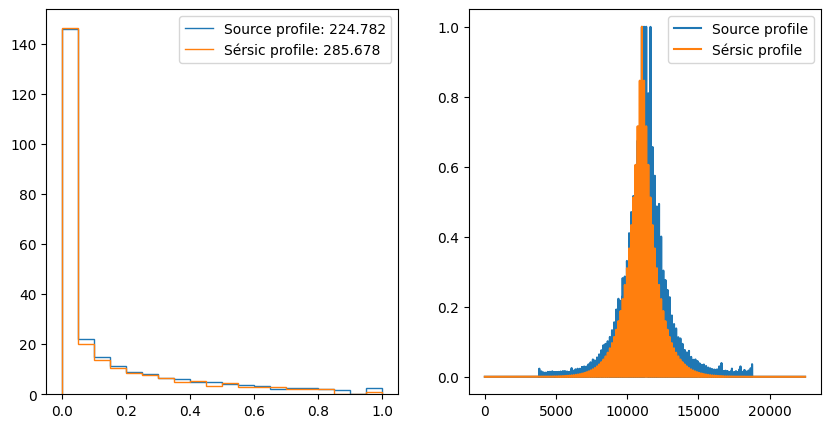

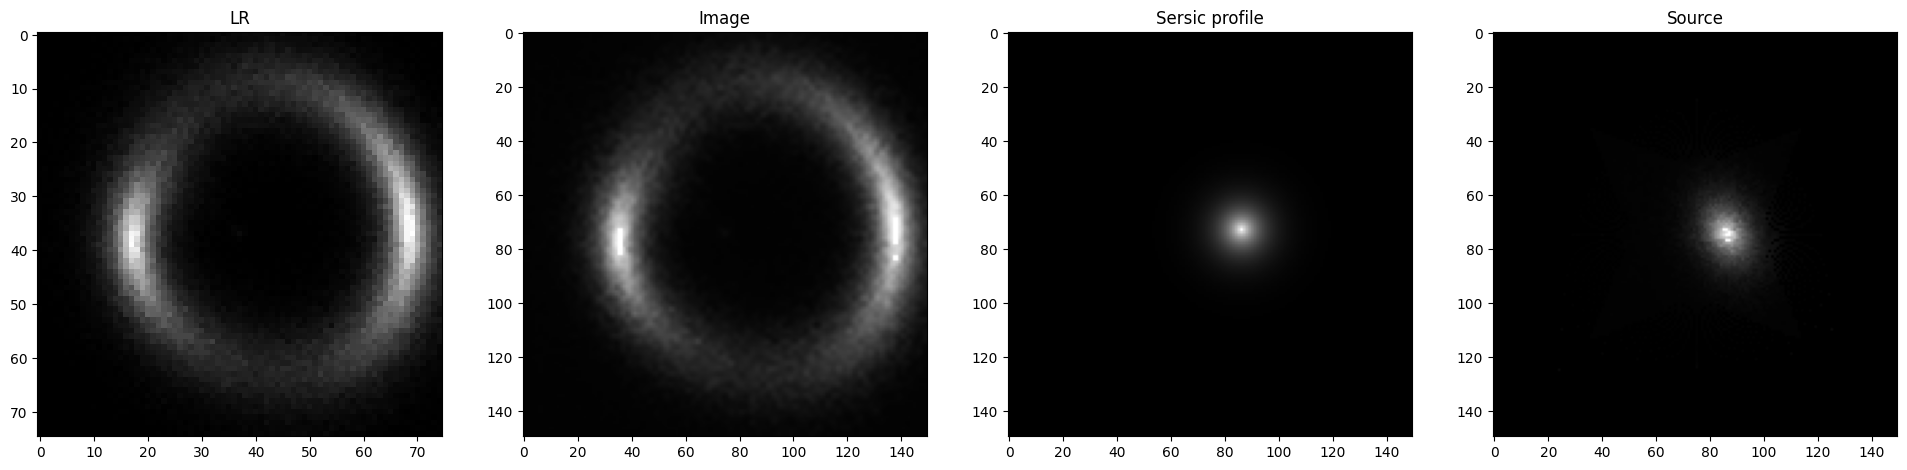

In [8]:
show_random_image(give_random_image(val_dataset, i_model, len(val_dataset)))

In [4]:
def origin_shift(source, shift):
    return source - shift

In [5]:
alpha = torch.tensor([[config["alpha"] for _ in range(IN_SHAPE*MAGNIFICATION*N_MAG)] for __ in range(IN_SHAPE*MAGNIFICATION*N_MAG)])

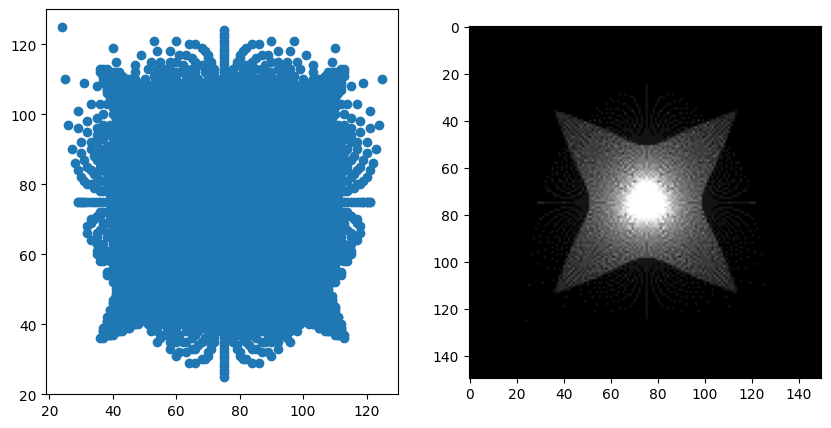

In [33]:
pos_y = torch.tensor([[i for _ in range(IN_SHAPE*MAGNIFICATION*N_MAG)]for i in range(IN_SHAPE*MAGNIFICATION*N_MAG-1,-1,-1)])
pos_x = torch.tensor([[i for i in range(IN_SHAPE*MAGNIFICATION*N_MAG)]for _ in range(IN_SHAPE*MAGNIFICATION*N_MAG)])
pos_x = origin_shift(pos_x, IN_SHAPE*MAGNIFICATION*N_MAG//2)*resolution
pos_y = origin_shift(pos_y, IN_SHAPE*MAGNIFICATION*N_MAG//2)*resolution
# pos_x, pos_y = pos_x.flatten(), pos_y.flatten()
r = torch.sqrt(pos_x**2+pos_y**2) #r(i,j) in pixel indices
theta = torch.arctan2(input=pos_y,other=pos_x) #theta(x,y)
device = device
resolution = resolution

dest_r = r-alpha
dest_x, dest_y = torch.round(dest_r/resolution*torch.cos(theta)).int(), torch.round(dest_r/resolution*torch.sin(theta)).int()
dest_y = torch.flip(dest_y, dims=[0])
dest_x, dest_y = origin_shift(dest_x, -IN_SHAPE*MAGNIFICATION*N_MAG//2), origin_shift(dest_y, -IN_SHAPE*MAGNIFICATION*N_MAG//2)

plot, axes = plt.subplots(1,2)
dext_x, dest_y = dest_x.view(1,-1), dest_y.view(1,-1)
dest_indices = dest_y*IN_SHAPE*MAGNIFICATION*N_MAG+dext_x
dest_indices = dest_indices.type(torch.int64)
image = torch.ones(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
B, _, x, y = image.shape
image = image.view(image.shape[0],-1)
source_profile = torch.zeros_like(image)
source_profile = source_profile.scatter_add_(1, dest_indices.view(B,-1), image.view(image.shape[0],-1)).view(B,1,x,y)
plot.set_size_inches(10,5)
axes[0].scatter(dest_x, dest_y)
axes[1].imshow(Image.fromarray(source_profile.numpy()[0][0]*20))

In [ ]:
Image.fromarray(source_profile.numpy()[0][0]*2.5).save('images.gif',save_all=True, append_images = [Image.fromarray(source_profile.numpy()[0][0]*2.5*i) for i in range(2,20)], optimize=False, duration=200, loop=0)